In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt

In [42]:
def clean_time(time):
    nums = [int(x) for x in time.split(':')]
    hours, mins, secs = nums[0], nums[1], nums[2]
    mins = hours * 60 + mins + secs / 60
    return mins

df = pd.read_excel('data.xlsx')
df['time'] = df['time'].apply(clean_time)
df['is_male'] = df['gender'].map({
    'male': 1,
    'female': 0
})
df['is_in_club'] = df['club'].notna().astype(int)


In [43]:
df = pd.read_csv('tz_output.csv')

In [44]:
df.head(10)

,time,first_name,trained_10_week,trained_im,has_trainer,Age,VO2 Max,BMI,n Marathons run,Cadence,is_male,in_club
0,226.000000,Madge,0,3,0,36.0,12.718323,NaN,0.0,163.0,False,False
1,206.666667,Vaida,3,5,0,30.0,12.718323,19.05,0.0,157.0,False,False
2,206.616667,Melissa,5,6,0,38.0,13.460000,21.13,0.0,165.0,False,False
3,201.183333,James,0,1,0,38.0,20.010000,18.86,0.0,154.0,True,True
4,200.683333,Cheryl,0,4,0,43.0,12.718323,19.75,0.0,166.0,False,False
5,198.400000,Joanne,5,5,0,42.0,21.030000,19.73,0.0,167.0,False,False
6,198.400000,Diane,5,5,0,32.0,14.470000,22.00,0.0,155.0,False,False
7,198.383333,Honor,2,7,0,41.0,20.720000,19.35,0.0,157.0,False,False
8,198.383333,Linda,0,0,0,33.0,12.718323,20.11,0.0,157.0,False,False
9,198.366667,Sky,4,5,0,37.0,12.180000,18.19,0.0,165.0,False,False


In [45]:
TARGET = 'time'
ID_COLS = ['is_male', 'in_club', 'trained_10_week', 'trained_im', 'has_trainer', 'Age', 'VO2 Max', 'BMI', 'n Marathons run', 'Cadence']
X = df.drop(columns=[TARGET])
X = X.select_dtypes(include=[np.number])
y = df[TARGET]

In [46]:
corrs = {}
for c in X.columns:
    valid = df[[c, TARGET]].dropna()
    if len(valid) >= 30:
        corrs[c] = valid[c].corr(valid[TARGET])
corrs = pd.Series(corrs).dropna().sort_values(key=lambda s: s.abs(), ascending=False)

top8 = corrs.head(8)
display(top8)  

VO2 Max           -0.873231
n Marathons run   -0.709391
BMI               -0.656784
Cadence           -0.503296
trained_10_week   -0.473501
trained_im        -0.391059
has_trainer       -0.171099
Age               -0.054763
dtype: float64

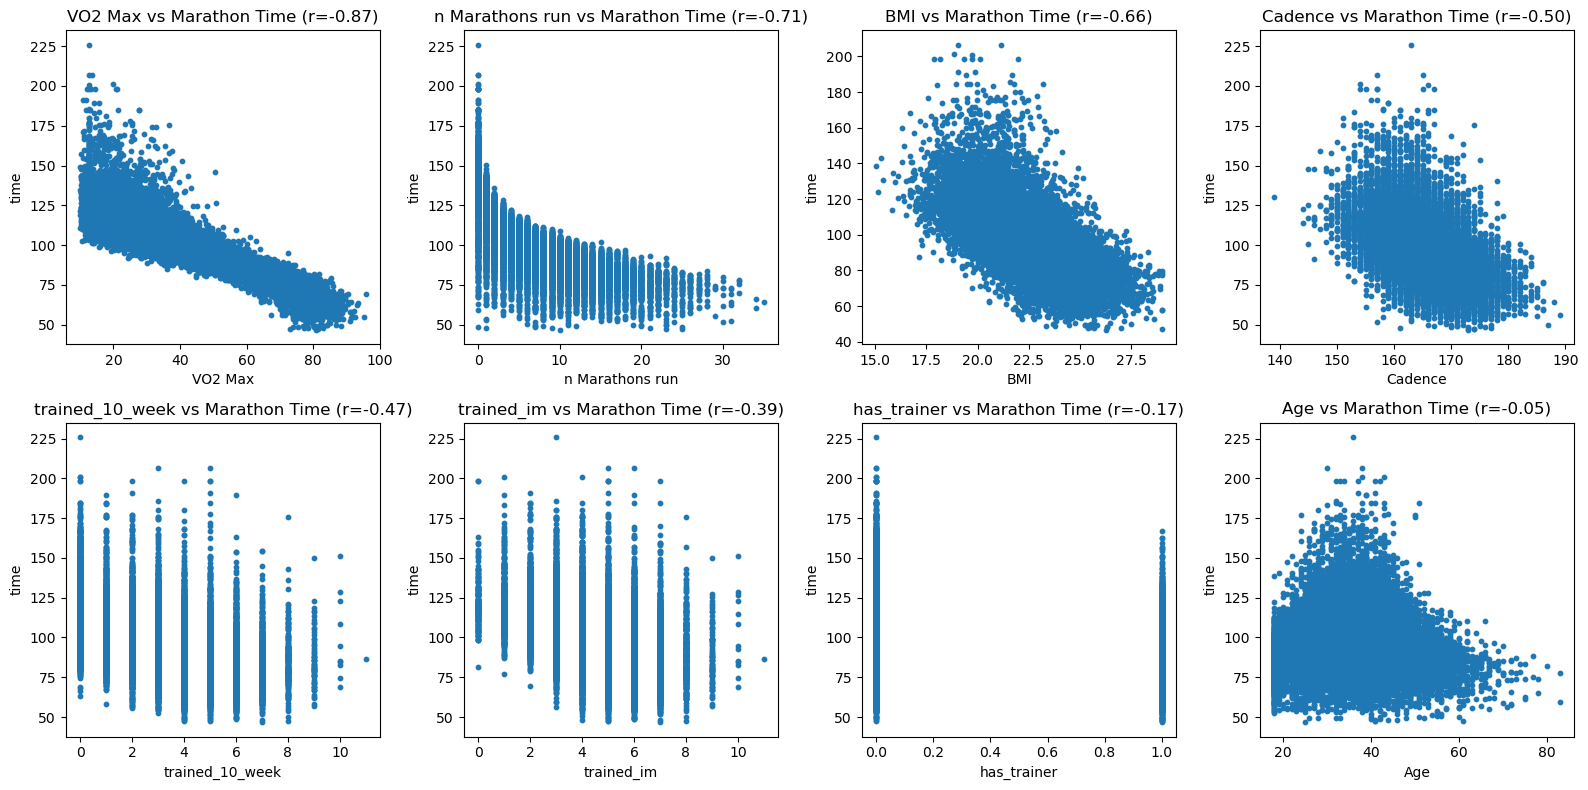

In [47]:
cols = top8.index.tolist()
n = len(cols)
rows = (n + 3)//4
plt.figure(figsize=(16, 4*rows))
for i, c in enumerate(cols, 1):
    ax = plt.subplot(rows, 4, i)
    valid = df[[c, TARGET]].dropna()
    ax.scatter(valid[c], valid[TARGET], s=10)
    ax.set_xlabel(c); ax.set_ylabel(TARGET)
    ax.set_title(f"{c} vs Marathon Time (r={valid[c].corr(valid[TARGET]):.2f})")
plt.tight_layout(); plt.show()

In [50]:
TARGET = 'time'
FEATURES = [
    'is_male', 'is_in_club',
    'trained_10_week', 'trained_im', 'has_trainer',
    'Age', 'VO2 Max', 'BMI', 'n Marathons run', 'Cadence'
]
FEATURES = [c for c in FEATURES if c in df.columns]
mask = df[FEATURES + [TARGET]].notnull().all(axis=1)
X = df.loc[mask, FEATURES]
y = df.loc[mask, TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=43))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} | R²: {r2:.4f}")

coef = pipe.named_steps["model"].coef_
intercept = pipe.named_steps["model"].intercept_
for name, w in zip(FEATURES, coef):
    print(f"{name:20s} {w: .6f}")
print("intercept:", intercept)

MSE: 91.2538 | RMSE: 9.5527 | R²: 0.7901
is_male              -0.681118
trained_10_week      -0.685615
trained_im           -0.805563
has_trainer          -0.307990
Age                   0.306618
VO2 Max              -11.024728
BMI                  -2.951345
n Marathons run      -3.737869
Cadence              -1.737993
intercept: 98.22453063241107


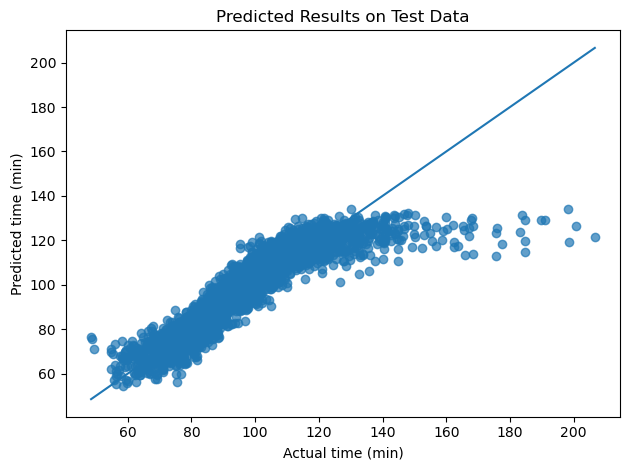

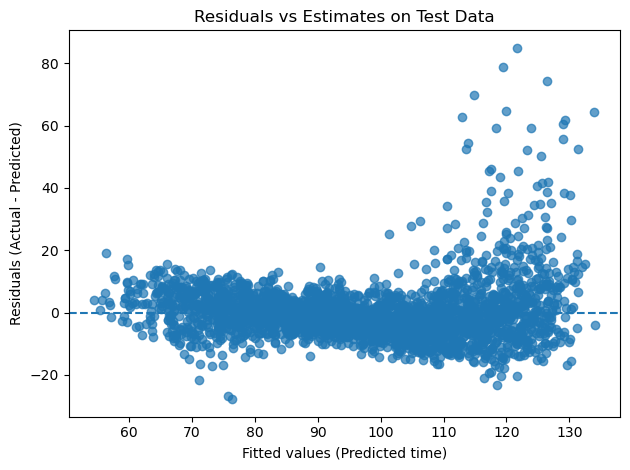

In [54]:
feature_names = FEATURES
y_hat_train = pipe.predict(X_train)
y_hat_test  = pipe.predict(X_test)
res_train = y_train - y_hat_train
res_test  = y_test  - y_hat_test

plt.figure()
plt.scatter(y_test, y_hat_test, alpha=0.7)
lims = [min(y_test.min(), y_hat_test.min()), max(y_test.max(), y_hat_test.max())]
plt.plot(lims, lims)  # 45-degree line
plt.xlabel("Actual time (min)")
plt.ylabel("Predicted time (min)")
plt.title("Predicted Results on Test Data")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_hat_test, res_test, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values (Predicted time)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Estimates on Test Data")
plt.tight_layout()
plt.show()

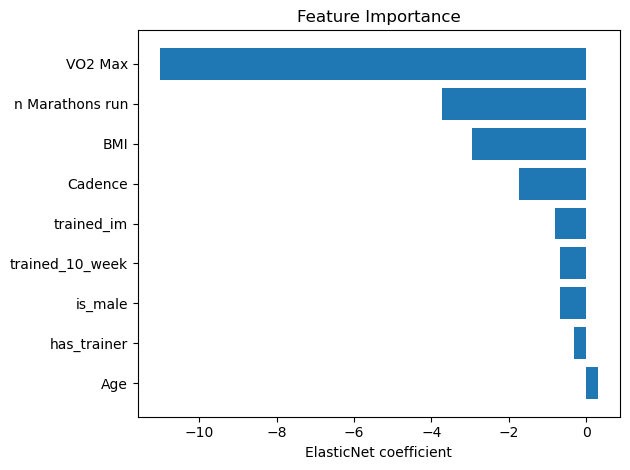

In [66]:
enet = pipe.named_steps["model"]
coefs = enet.coef_
order = np.argsort(np.abs(coefs))[::-1]
sorted_names = np.array(feature_names)[order]
sorted_coefs = coefs[order]

plt.figure()
ypos = np.arange(len(sorted_names))
plt.barh(ypos, sorted_coefs)
plt.yticks(ypos, sorted_names)
plt.gca().invert_yaxis()
plt.xlabel("ElasticNet coefficient")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

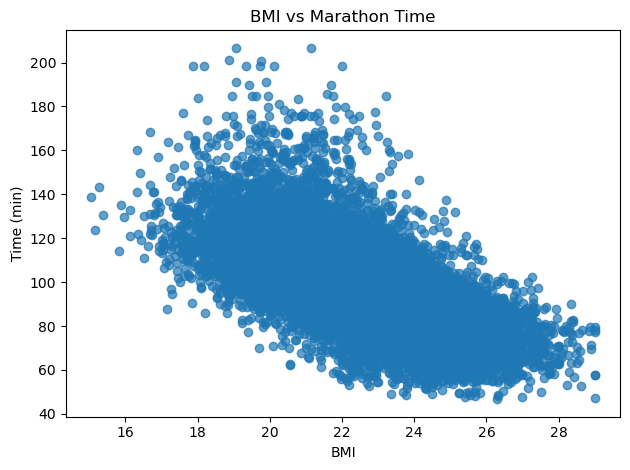

In [58]:
plt.figure()
plt.scatter(df['BMI'], df['time'], alpha=0.7)
plt.xlabel("BMI")
plt.ylabel("Time (min)")
plt.title("BMI vs Marathon Time")
plt.tight_layout()
plt.show()

In [62]:
new_runner = pd.DataFrame([{
    'is_male': 0,
    'trained_10_week': 2,
    'trained_im': 4,
    'has_trainer': 1,
    'Age': 17,
    'VO2 Max': 52,
    'BMI': 19,
    'n Marathons run': 0,
    'Cadence': 155
}])

predicted_time = pipe.predict(new_runner)[0]
print(f"Predicted marathon time: {predicted_time:.2f} minutes")

Predicted marathon time: 106.59 minutes


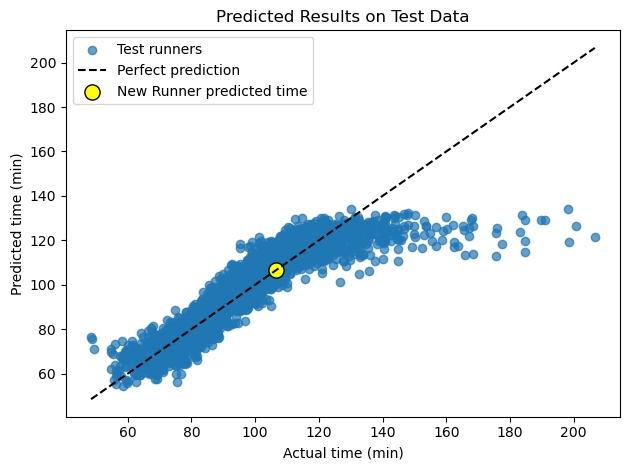

In [65]:
plt.figure()
plt.scatter(y_test, y_hat_test, alpha=0.7, label="Test runners")

lims = [min(y_test.min(), y_hat_test.min()), max(y_test.max(), y_hat_test.max())]
plt.plot(lims, lims, color='black', linestyle='--', label="Perfect prediction")
plt.scatter(predicted_time, predicted_time, color='Yellow', s=120, edgecolor='black', label="New Runner predicted time")
plt.xlabel("Actual time (min)")
plt.ylabel("Predicted time (min)")
plt.title("Predicted Results on Test Data")
plt.legend()
plt.tight_layout()
plt.show()
